### 1 Data manipulation

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 300)

# access data and extract c1 and c2 closed price
price = pd.read_csv('./Data/S_price.csv',index_col = 0)
price.index = pd.to_datetime(price.index, format = '%Y%m%d')
s = price[['Close1', 'Close2']]

# carry
s['carry'] = (s['Close1'] - s['Close2']) / s['Close1']

# hedging pressure
hp_df = pd.read_csv('./Data/S_hp.csv', index_col = 0)
hp_df.index = pd.to_datetime(hp_df.index)
s = pd.concat([s, pd.DataFrame(hp_df['Hedging_Pressure_Variable'])],axis = 1,join = 'outer')
# forward assign
for i in range(1,s.shape[0]):
    if np.isnan(s.iloc[i,3]) == True:
        s.iloc[i,3] = s.iloc[i-1,3]
# backward assign
#for i in range((s.shape[0]-1), 0):
 #   if np.isnan(s.iloc[i,3]) == True:
  #      s.iloc[i,3] = s.iloc[i-1,3]
s = s.rename(columns = {'Hedging_Pressure_Variable':'hp'})
s = s.dropna()

The carry calculation provides insight into the relative pricing and market expectations embedded in the futures curve. A positive carry (when 'Close1' is greater than 'Close2') might suggest that holding the near contract is beneficial if prices are expected to converge at the levels of the far contract. Conversely, a negative carry could indicate that the market expects prices to decline, and it might be more beneficial to hold the far contract.

,Close1,Close2,carry,hp
Date,,,,
1991-04-01,598.50,611.50,-0.021721,-0.194804
1991-04-02,594.50,606.50,-0.020185,-0.194804
1991-04-03,587.00,601.25,-0.024276,-0.194804
1991-04-04,585.25,597.75,-0.021358,-0.194804
1991-04-05,588.75,601.50,-0.021656,-0.194804
...,...,...,...,...
2023-01-05,1466.75,1470.75,-0.002727,-0.163719
2023-01-06,1501.50,1492.50,0.005994,-0.163719
2023-01-09,1503.50,1488.50,0.009977,-0.163719


<AxesSubplot:xlabel='Date'>

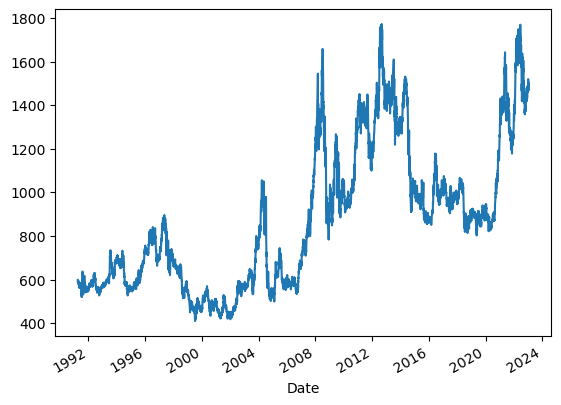

In [2]:
s['Close1'].plot()

### 2 Backtesting code

In [12]:
def bt(data, price_name, signal_name, t_cost, initial_account = 1, target_vol = 1):
    
    # translate t_cost from bp to real measurement
    t_cost = t_cost / 10000 
    
    # data preparation
    df = pd.DataFrame(data[price_name])
    df.columns = ['price']
    df['ret'] = df['price'].pct_change()
    df['signal'] = data[signal_name]
    df['vol_60'] = df['ret'].ewm(span = 60, min_periods = 60).std() * np.sqrt(252)
    df['position'] = ((initial_account * target_vol * df['signal']) / df['vol_60']).shift(2)
    df['position_change'] = df['position'].diff()
    df = df.dropna()
    
    # cost and PnL calculation
    df['pnl_bc'] = df['ret'] * df['position']
    df['t_cost'] = t_cost * abs(df['position_change'])
    df['pnl'] = df['pnl_bc'] - df['t_cost']
    
    # plot
    df[['pnl_bc','pnl']].cumsum().plot(title = 'PnL with turnover = ' + str(to(df)))
    plt.legend(['Before cost SR = ' + str(sr(df['pnl_bc'])),
               'After cost SR = ' + str(sr(df['pnl']))])
    plt.show()
    
    return df

def sr(ret):
    sr = (ret.mean() / ret.std()) * np.sqrt(252)
    return round(sr,2)

def to(df):
    turnover = abs(df['position_change']).sum() / abs(df['position']).sum()
    return round(turnover,2)

def z_score(col_df, cap = 2):
    col_df = pd.DataFrame(col_df)
    col_ewma = col_df.ewm(span = 30, min_periods = 30).mean()
    col_std = col_df.ewm(span = 30, min_periods = 30).std()
    col = col_ewma / col_std
    col.clip(lower = -cap, upper = cap, inplace = True)
    return col

### 3 Carry

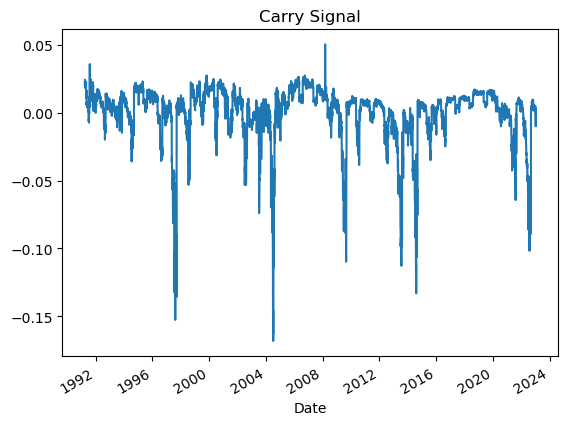

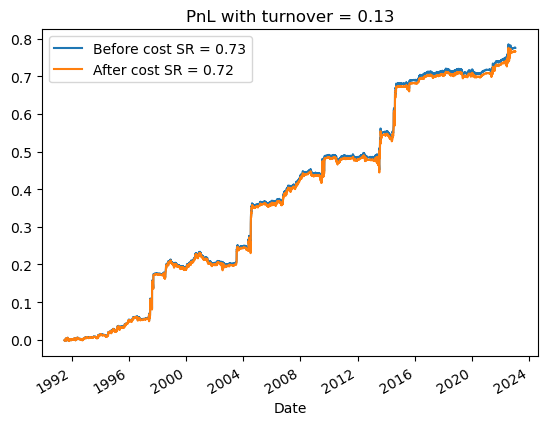

In [13]:
s['carry_signal'] = s['carry'] * (-1)
s['carry_signal'].plot(title = 'Carry Signal')
c1_carry = bt(s,'Close1','carry_signal', 1.5)

### 4 Hedging pressure

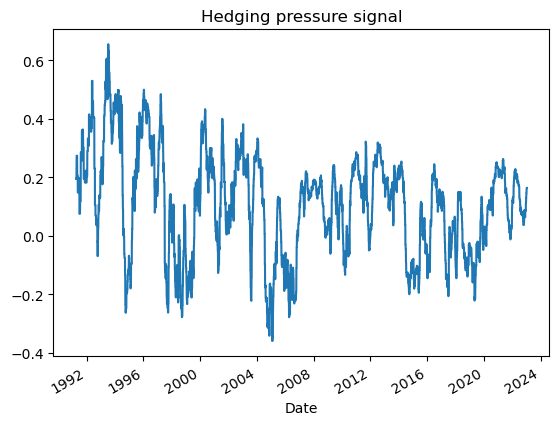

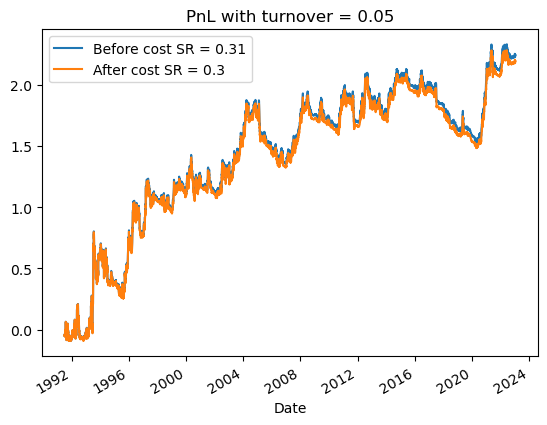

In [5]:
s['hp_signal'] = s['hp'] * (-1)
s['hp_signal'].plot(title = 'Hedging pressure signal')
c1_hp = bt(s,'Close1','hp_signal',1.5)

### 5 Combined signal

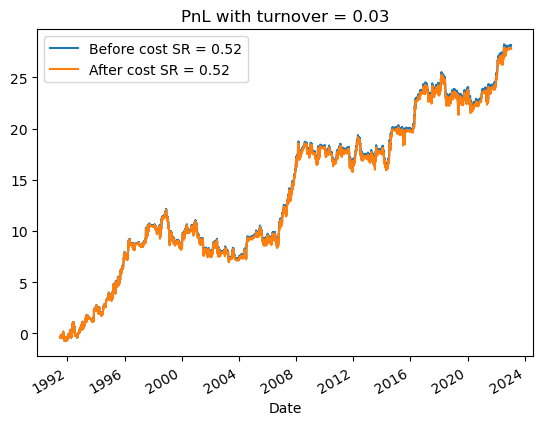

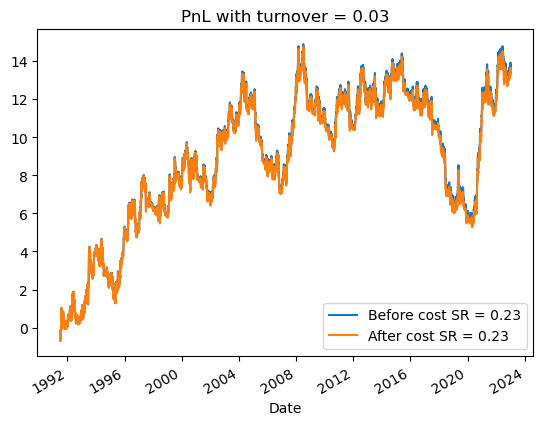

,price,ret,signal,vol_60,position,position_change,pnl_bc,t_cost,pnl
Date,,,,,,,,,
1991-06-28,528.00,-0.038251,2.0,0.180099,14.846381,0.239682,-0.567894,0.000036,-0.567930
1991-07-01,532.50,0.008523,2.0,0.180264,13.814802,-1.031580,0.117740,0.000155,0.117585
1991-07-02,531.25,-0.002347,2.0,0.176885,11.105026,-2.709776,-0.026068,0.000406,-0.026475
1991-07-03,533.25,0.003765,2.0,0.174699,11.094851,-0.010175,0.041769,0.000002,0.041767
1991-07-05,530.00,-0.006095,2.0,0.171786,11.306788,0.211937,-0.068912,0.000032,-0.068943
...,...,...,...,...,...,...,...,...,...
2023-01-05,1466.75,-0.007779,2.0,0.194625,10.061071,-0.392753,-0.078270,0.000059,-0.078329
2023-01-06,1501.50,0.023692,2.0,0.202781,10.180994,0.119923,0.241206,0.000018,0.241188
2023-01-09,1503.50,0.001332,2.0,0.199431,10.276148,0.095154,0.013688,0.000014,0.013674


In [6]:
s['carry_z_signal'] = z_score(s['carry_signal'])
s['hp_z_signal'] = z_score(s['hp_signal'])

bt(s,'Close1','carry_z_signal', 1.5)
bt(s,'Close1','hp_z_signal', 1.5)

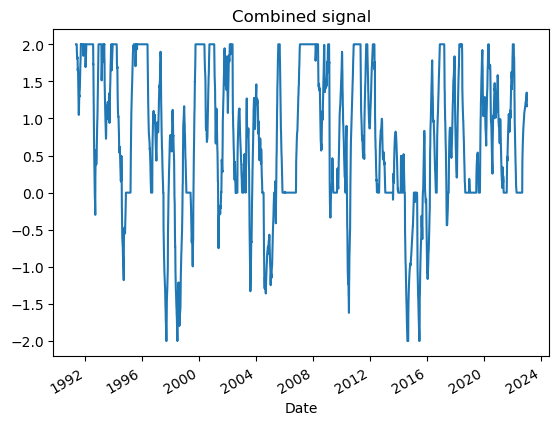

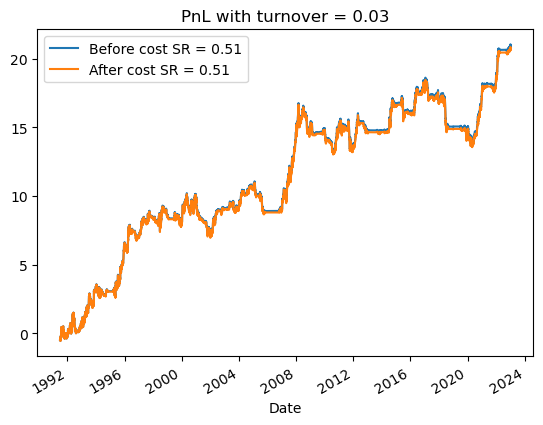

In [7]:
s['combined_signal'] = (s['carry_z_signal'] + s['hp_z_signal']) / 2
s['combined_signal'].plot(title = 'Combined signal')
c1_combined = bt(s,'Close1','combined_signal', 1.5)